In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import random
import pandas as pd
import itertools
from itertools import cycle
pd.set_option('display.max_columns', None)

import seaborn as sns

from sqlalchemy import create_engine
engine = create_engine("sqlite:///class1.db")
data = pd.read_sql('''SELECT * FROM spotify
                   WHERE genre != 'Dark Trap' AND genre != 'Trap Metal' AND genre != 'trap' AND genre != 'Rap' AND genre != 'Hiphop' AND genre != 'RnB';''', engine)

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, accuracy_score, confusion_matrix

## Random Forest

In [2]:
df = data
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.763,0.480,4,-14.593,0,0.3560,0.246000,0.000000,0.3620,0.7420,204.094,221597,4,Underground Rap
1,0.362,0.979,7,-5.643,1,0.8170,0.003290,0.003650,0.5470,0.0387,160.072,169255,4,Underground Rap
2,0.793,0.777,1,-8.026,1,0.0860,0.002250,0.062900,0.5040,0.7040,165.008,152773,4,Underground Rap
3,0.657,0.914,7,-4.631,1,0.1700,0.012000,0.086100,0.2330,0.6260,160.048,158825,5,Underground Rap
4,0.735,0.512,4,-9.889,0,0.1630,0.063200,0.000524,0.1140,0.2140,188.060,145682,4,Underground Rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25804,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,4,hardstyle
25805,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,4,hardstyle
25806,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,4,hardstyle
25807,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,4,hardstyle


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25809 entries, 0 to 25808
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      25809 non-null  float64
 1   energy            25809 non-null  float64
 2   key               25809 non-null  int64  
 3   loudness          25809 non-null  float64
 4   mode              25809 non-null  int64  
 5   speechiness       25809 non-null  float64
 6   acousticness      25809 non-null  float64
 7   instrumentalness  25809 non-null  float64
 8   liveness          25809 non-null  float64
 9   valence           25809 non-null  float64
 10  tempo             25809 non-null  float64
 11  duration_ms       25809 non-null  int64  
 12  time_signature    25809 non-null  int64  
 13  genre             25809 non-null  object 
dtypes: float64(9), int64(4), object(1)
memory usage: 2.8+ MB


In [4]:
features = df.columns[:12]
genres = np.unique(df.genre)

In [5]:
genres

array(['Emo', 'Pop', 'Underground Rap', 'dnb', 'hardstyle', 'psytrance',
       'techhouse', 'techno', 'trance'], dtype=object)

In [6]:
X = data[features].copy()
y = LabelEncoder().fit_transform(data['genre'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=21, shuffle=True)

In [8]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [9]:
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

In [10]:
def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(genres))
    print('Val Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Val Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=genres)

In [11]:
rf = RandomForestClassifier(n_estimators = 400, random_state = 21)

## Validation Set

In [13]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400, random_state=21)

In [14]:
rf_probs = rf.predict_proba(X_val)

Test Set Accuracy =  0.91
Test Set F-score =  0.83
ROC AUC = 0.984
Confusion matrix, without normalization
[[ 246   10   47    4   18    0    1    1    9]
 [  23   14   47    0    2    0    3    0    3]
 [  12    5 1132    4    9    0    7    0    6]
 [   3    0    5  585    0    0    0    0    0]
 [   3    0    4    0  570    9    0    0    1]
 [   0    0    2    0    5  537    1   13   35]
 [   2    1    9    0    0    0  547   30    6]
 [   0    0    3    0    0   13   41  514   20]
 [   7    0    5    0    0   17   10   28  533]]


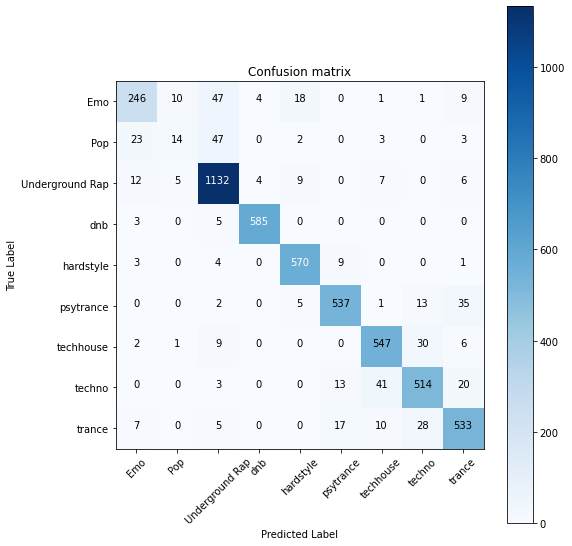

In [15]:
display_results(y_val, rf_probs, cm=True)

## Test Set

In [ ]:
rf.fit(X_train, y_train)

In [16]:
rf_probs = rf.predict_proba(X_test)

Test Set Accuracy =  0.92
Test Set F-score =  0.84
ROC AUC = 0.986
Confusion matrix, without normalization
[[ 256    8   51    2   10    1    1    0    7]
 [  20   13   52    1    0    0    3    0    3]
 [  19    2 1133    3    3    0   10    0    5]
 [   2    0    3  589    0    0    0    0    0]
 [   4    0    5    0  573    5    0    0    0]
 [   0    0    1    0    0  550    0    9   32]
 [   1    1    9    0    0    0  544   34    6]
 [   0    0    2    0    0   12   40  514   23]
 [   3    0    6    0    0   11    2   26  552]]


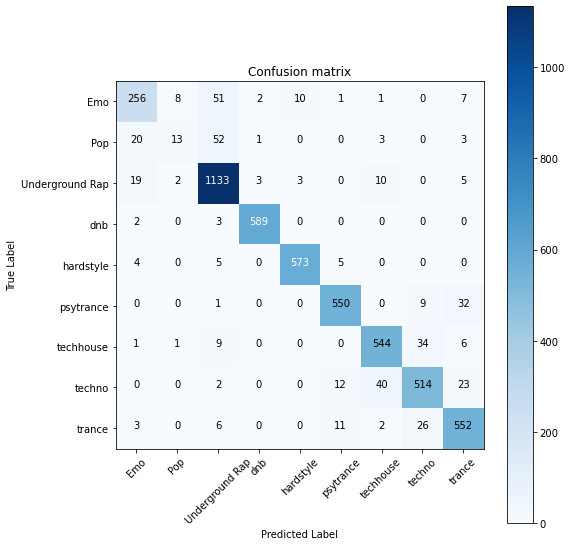

In [17]:
display_results(y_test, rf_probs, cm=True)